In [1]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *


from src import plot_utils
from src import inpaint_utils
from src import fiberatlas_utils

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

## Description


In [16]:
scale = 2 # Change to modify the scale

connFilename = f'../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]

# NOTE; use the masks if necessary when 
# we select too much bundles for reconstruction
gm_mask_subj = nib.load('../../atlas_data/moviedata_fMRI_eg/gm_mask_subj7.nii').get_fdata() 
wm_mask_subj = (gm_mask_subj + 1) % 2

region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']

index_of_interest = np.where([(region_of_interest[0] in gmregions.astype(str)) or (region_of_interest[1] in gmregions.astype(str))
                      for gmregions in gmregions_names])[0]

index_of_interest = np.array(index_of_interest)
gmregions_names[index_of_interest]

array([b'ctx-rh-posteriorcingulate_1', b'ctx-lh-posteriorcingulate_1'],
      dtype='|S49')

#### Compute the pcc  with inpainting models

In [17]:
### Compute the pcc seed connectivity
# Load the rest fmri in MNI space volumes

ftimecourse = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii').get_fdata()
rest_affine = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii').affine

# Visualize the corresponding probabilstic voxels for this region
root = '../../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'
atlas_of_interest = f'compresslausanne2018.scale{scale}.sym.corrected.ctx+subc.volspams.nii.gz'
prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata(), nib.load(root + atlas_of_interest).affine)

# threshold the prob_regions into binary mask
thresh = 0.1  # empirically chosen thresh to have at least 3 subjects overlap on that region
mask_regions = (prob_regions > thresh).astype(float)

rmask_regions_nifti = nimg.resample_to_img(nib.Nifti1Image(mask_regions, affine=prob_affine), 
                                           nib.Nifti1Image(ftimecourse[:,:,:,0], affine=rest_affine), interpolation = 'nearest')
rmask_regions = rmask_regions_nifti.get_fdata()

In [18]:
thresh_subjapp = int(np.ceil(nsubject * 0.1)) 
bundle_affine = np.array(hf.get('header').get('affine'))[()]

voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
vdim = voxel_fmri.shape[:3]
fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')

bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))

100%|██████████| 141/141 [01:43<00:00,  1.36it/s]


In [19]:
ps = [(0,0), (1e-2,1e-2), (1e-1,1e-1), (1,1), (10,10), (100,100)]
p1,p2 = ps[0]
bundle_opt = load(f"../resources/weights_regressors_activity/weighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}_p1-{p1}_p2-{p2}.pkl")

p1,p2 = ps[1]
bundle_opt2 = load(f"../resources/weights_regressors_activity/weighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}_p1-{p1}_p2-{p2}.pkl")

p1,p2 = ps[2]
bundle_opt3 = load(f"../resources/weights_regressors_activity/weighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}_p1-{p1}_p2-{p2}.pkl")

In [20]:
from scipy.ndimage import gaussian_filter1d

tmp = np.concatenate([ftimecourse[rmask_regions[:,:,:,k + 1].astype(bool)] for k in index_of_interest])
movie_mean = np.mean([gaussian_filter1d(tmp[k],1.2) for k in range(len(tmp))],axis=0)

In [21]:
seedfunc_hyperparams = {}
bundles = [bundle_opt, bundle_opt2, bundle_opt3]
for hidx in range(len(bundles)):
    # Inpainting
    tmparray_lasso = []
    for k in tqdm(range(ftimecourse.shape[-1])):
        tmp_inpainted, tmp_inpainted2 = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundles[hidx][k], vdim, 
                                                            wmmask=wm_mask_subj, normalizing=True, verbose=False)
        tmparray_lasso.append(tmp_inpainted)
    tmparray_lasso = np.array(tmparray_lasso)

    # Computing seed connectivity
    seedfunc_vol = np.zeros((ftimecourse.shape[:-1]))
    for x in tqdm(range(seedfunc_vol.shape[0])):
        for y in range(seedfunc_vol.shape[1]):
            for z in range(seedfunc_vol.shape[2]):
                seedfunc_vol[x,y,z] = pearsonr(movie_mean, tmparray_lasso[:,x,y,z])[0]

    seedfunc_hyperparams[hidx] = deepcopy(seedfunc_vol)

  0%|          | 0/91 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 91/91 [00:56<00:00,  1.60it/s]


/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


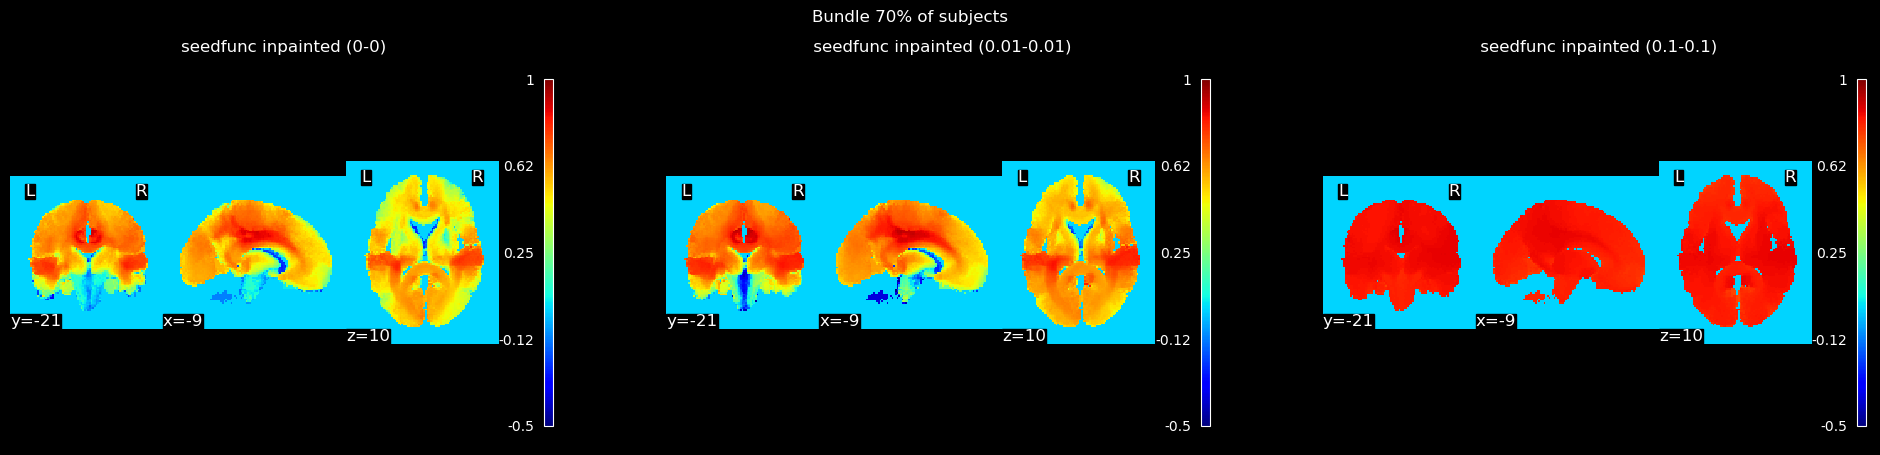

In [22]:
inpaint_mods = [seedfunc_hyperparams[0], seedfunc_hyperparams[1], seedfunc_hyperparams[2]]

all_inpaints_names = f'seedfunc inpainted (0-0), seedfunc inpainted (0.01-0.01), seedfunc inpainted (0.1-0.1)'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-0.5, vmax=1)

In [ ]:
# hierarchical clustering coarsest and widest level
# is there nice splits of the wm connectivit
# NOTE: Close the opened h5 file
hf.close()